# Minimal NeRF Demo — LEGO Scene

Implimentation adapted from [yenchenlin/nerf-pytorch](https://github.com/yenchenlin/nerf-pytorch)

In [ ]:

from pathlib import Path
import json
import math
import random

# Image and array helpers
import imageio.v2 as imageio
import numpy as np
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


## 2. Positional Encoding and NeRF Network
NeRF follows the paper notation and lifts each 3D location $\mathbf{x}$ and viewing direction $\mathbf{d}$ into a richer signal with the positional encoding

$\gamma(\mathbf{u}) = (\mathbf{u}, \sin(2^{0}\mathbf{u}), \cos(2^{0}\mathbf{u}), \ldots, \sin(2^{L-1}\mathbf{u}), \cos(2^{L-1}\mathbf{u}))$

This encoding lets the network keep high frequency detail while still using a simple multilayer perceptron.

The network $F_{\Theta}$ produces a volume density $\sigma$ and emitted color $\mathbf{c}$:

$F_{\Theta}(\gamma(\mathbf{x}), \gamma(\mathbf{d})) = (\mathbf{c}, \sigma)$

PositionalEncoder.forward builds $\gamma(\mathbf{u})$ band by band. NeRF.forward applies the ReLU layers with one skip connection, then splits the output into $\sigma$ and a feature vector that mixes with the encoded view direction before the color head.

In [25]:
class PositionalEncoder(nn.Module):
    def __init__(self, num_frequencies: int, include_input: bool = True):
        super().__init__()
        # Store number of frequency bands
        self.num_frequencies = num_frequencies
        self.include_input = include_input
        self.output_dim = 0
        if include_input:
            # Count raw xyz channels
            self.output_dim += 3
        # Each band adds sine and cosine for xyz
        self.output_dim += 6 * num_frequencies

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        # Collect encoded bands
        encodings = []
        if self.include_input:
            # Keep raw xyz term
            encodings.append(inputs)
        for i in range(self.num_frequencies):
            freq = 2.0**i * math.pi
            # Add sine band
            encodings.append(torch.sin(freq * inputs))
            # Add cosine band
            encodings.append(torch.cos(freq * inputs))
        return torch.cat(encodings, dim=-1)


class NeRF(nn.Module):
    def __init__(self, depth: int = 8, width: int = 256, skips=(4,), num_freqs_xyz: int = 10, num_freqs_dir: int = 4):
        super().__init__()
        self.skips = skips
        self.encoder_xyz = PositionalEncoder(num_freqs_xyz)
        self.encoder_dir = PositionalEncoder(num_freqs_dir)

        in_ch_xyz = self.encoder_xyz.output_dim
        in_ch_dir = self.encoder_dir.output_dim

        layers = []
        for i in range(depth):
            if i == 0:
                # First layer reads encoded xyz
                layers.append(nn.Linear(in_ch_xyz, width))
            elif i in skips:
                # Skip layer joins activations with encoding
                layers.append(nn.Linear(width + in_ch_xyz, width))
            else:
                # Standard hidden layer
                layers.append(nn.Linear(width, width))
        self.layers = nn.ModuleList(layers)
        self.sigma_linear = nn.Linear(width, 1)
        self.feature_linear = nn.Linear(width, width)
        self.rgb_linear = nn.Linear(width + in_ch_dir, 3)

    def forward(self, x: torch.Tensor, d: torch.Tensor) -> torch.Tensor:
        # Encode xyz and view direction
        x_encoded = self.encoder_xyz(x)
        d_encoded = self.encoder_dir(d)

        h = x_encoded
        for i, layer in enumerate(self.layers):
            if i in self.skips:
                # Inject skip connection features
                h = torch.cat([h, x_encoded], dim=-1)
            h = layer(h)
            h = F.relu(h)

        sigma = F.relu(self.sigma_linear(h))
        feat = self.feature_linear(h)
        feat = F.relu(feat)
        h = torch.cat([feat, d_encoded], dim=-1)
        rgb = torch.sigmoid(self.rgb_linear(h))
        return torch.cat([rgb, sigma], dim=-1)


## 3. Dataset Loader
Each Blender frame stores a camera to world transform $T_{c\rightarrow w}$ and the horizontal field of view $\theta_x$. The focal length follows the paper with

$f = \frac{0.5\, W}{\tan(0.5\, \theta_x)}$

The loader reads the JSON metadata, keeps the rotation and translation inside $T_{c\rightarrow w}$, and collects every RGB image as float values in $[0,1]$. These tensors feed the ray sampler later on.

In [28]:

def load_lego_dataset(dataset_root: Path):
    # Gather splits used for training and validation
    splits = ["train", "val"]
    metas = {}
    for split in splits:
        meta_path = dataset_root / f"transforms_{split}.json"
        if not meta_path.exists():
            raise FileNotFoundError(f"Missing metadata file: {meta_path}")
        with meta_path.open("r") as f:
            metas[split] = json.load(f)

    first_frame_path = dataset_root / f"{metas['train']['frames'][0]['file_path']}.png"
    if not first_frame_path.exists():
        raise FileNotFoundError(f"Image file referenced in JSON not found: {first_frame_path}")
    sample_img = imageio.imread(first_frame_path)
    if sample_img.ndim == 2:
        raise ValueError("Expected RGB(A) image, received grayscale.")
    height, width = sample_img.shape[:2]
    camera_angle_x = metas["train"]["camera_angle_x"]
    focal = 0.5 * width / math.tan(0.5 * camera_angle_x)

    def _load_split(split: str):
        # Load images and poses for one split
        imgs = []
        poses = []
        for frame in metas[split]["frames"]:
            img_path = dataset_root / f"{frame['file_path']}.png"
            img = imageio.imread(img_path)
            img = img[..., :3]
            # Normalize pixel values to zero one
            imgs.append(img.astype(np.float32) / 255.0)
            poses.append(np.array(frame["transform_matrix"], dtype=np.float32))
        return np.stack(imgs), np.stack(poses)

    train_imgs, train_poses = _load_split("train")
    val_imgs, val_poses = _load_split("val")
    return train_imgs, train_poses, val_imgs, val_poses, height, width, focal


## 4. Camera Rays and Pixel Sampling
For each pixel $(i,j)$ the camera space ray direction is

$\mathbf{d}_{ij} = \left( \frac{j - W/2}{f},\; -\frac{i - H/2}{f},\; -1 \right)$

Multiplying by $T_{c\rightarrow w}$ gives the world origin $\mathbf{o}$ and direction $\mathbf{d}$ so the ray is $\mathbf{o} + t\mathbf{d}$. create_ray_directions builds the camera grid, get_rays moves it to world space, and sample_random_rays draws a small random set of rays together with their target colors for training.

In [29]:

def create_ray_directions(height: int, width: int, focal: float, device: torch.device) -> torch.Tensor:
    # Build grid of pixel coordinates
    i_coords, j_coords = torch.meshgrid(
        torch.arange(height, dtype=torch.float32, device=device),
        torch.arange(width, dtype=torch.float32, device=device),
        indexing="ij",
    )
    dirs = torch.stack(
        [
            (j_coords - width * 0.5) / focal,
            -(i_coords - height * 0.5) / focal,
            -torch.ones_like(i_coords),
        ],
        dim=-1,
    )
    return dirs


def get_rays(directions: torch.Tensor, c2w: torch.Tensor):
    # Rotate directions into world space and set origin
    rays_d = torch.matmul(directions, c2w[:3, :3].T)
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    return rays_o, rays_d


def sample_random_rays(train_imgs: torch.Tensor, train_poses: torch.Tensor, directions: torch.Tensor, n_rays: int, device: torch.device):
    # Pick a random training image
    n_images, height, width, _ = train_imgs.shape
    img_idx = random.randint(0, n_images - 1)

    pose = train_poses[img_idx].to(device)
    rays_o, rays_d = get_rays(directions, pose)

    target = train_imgs[img_idx].to(device)
    coords_i = torch.randint(0, height, (n_rays,), device=device)
    coords_j = torch.randint(0, width, (n_rays,), device=device)

    # Gather the chosen rays and their colors
    rays_o = rays_o[coords_i, coords_j]
    rays_d = rays_d[coords_i, coords_j]
    pixel_rgb = target[coords_i, coords_j]
    return rays_o, rays_d, pixel_rgb


## 5. Volume Rendering
NeRF samples points $t_i$ along each ray between $t_{\text{near}}$ and $t_{\text{far}}$. Stratified sampling jitters the bins as in the paper. For each sample the renderer uses the weights

$w_i = T_i \left(1 - \exp(-\sigma_i \Delta_i)\right)$ with $T_i = \exp\left(-\sum_{j<i} \sigma_j \Delta_j\right)$

The expected color and depth are

$\hat{\mathbf{C}} = \sum_i w_i \mathbf{c}_i$, \quad $\hat{D} = \sum_i w_i t_i$

The helper volume_render_rays carries out these steps and render_image sweeps through every ray of a validation frame without perturbation. The full paper adds a second pass that draws extra points from the PDF $p(t_i) = w_i / \sum_j w_j$ using inverse transform sampling so high density regions receive more attention.

In [31]:

def volume_render_rays(model: NeRF, rays_o: torch.Tensor, rays_d: torch.Tensor, near: float, far: float, n_samples: int, perturb: bool):
    device = rays_o.device
    n_rays = rays_o.shape[0]
    # Sample depth values between near and far
    t_vals = torch.linspace(0.0, 1.0, steps=n_samples, device=device)
    z_vals = near * (1.0 - t_vals) + far * t_vals
    z_vals = z_vals.expand(n_rays, n_samples)

    if perturb:
        # Jitter bins for stratified sampling
        mids = 0.5 * (z_vals[:, 1:] + z_vals[:, :-1])
        upper = torch.cat([mids, z_vals[:, -1:]], dim=-1)
        lower = torch.cat([z_vals[:, :1], mids], dim=-1)
        t_rand = torch.rand(z_vals.shape, device=device)
        z_vals = lower + (upper - lower) * t_rand

    # Project sample points along each ray
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]
    view_dirs = F.normalize(rays_d, dim=-1)
    view_dirs = view_dirs[:, None, :].expand_as(pts)

    # Flatten for batched network query
    pts_flat = pts.reshape(-1, 3)
    view_dirs_flat = view_dirs.reshape(-1, 3)

    raw = model(pts_flat, view_dirs_flat)
    raw = raw.reshape(n_rays, n_samples, 4)

    rgbs = raw[..., :3]
    sigmas = raw[..., 3]

    # Compute distances between samples
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    delta_inf = torch.tensor([1e10], device=device).expand_as(deltas[:, :1])
    deltas = torch.cat([deltas, delta_inf], dim=-1)

    # Turn densities into alpha values and weights
    alphas = 1.0 - torch.exp(-sigmas * deltas)
    transmittance = torch.cumprod(
        torch.cat([torch.ones((n_rays, 1), device=device), 1.0 - alphas + 1e-10], dim=-1),
        dim=-1,
    )
    weights = alphas * transmittance[:, :-1]

    # Reduce weighted color depth opacity
    rgb_map = torch.sum(weights[..., None] * rgbs, dim=-2)
    depth_map = torch.sum(weights * z_vals, dim=-1)
    acc_map = torch.sum(weights, dim=-1)
    return rgb_map, depth_map, acc_map


def render_image(model: NeRF, directions: torch.Tensor, pose: torch.Tensor, near: float, far: float, n_samples: int, chunk: int):
    H, W, _ = directions.shape
    rays_o, rays_d = get_rays(directions, pose)
    rays_o = rays_o.reshape(-1, 3)
    rays_d = rays_d.reshape(-1, 3)

    rgb_chunks = []
    with torch.no_grad():
        for i in range(0, rays_o.shape[0], chunk):
            ro = rays_o[i : i + chunk]
            rd = rays_d[i : i + chunk]
            # Render chunk without stratified jitter
            rgb, _, _ = volume_render_rays(model, ro, rd, near, far, n_samples, perturb=False)
            rgb_chunks.append(rgb)
    rgb_full = torch.cat(rgb_chunks, dim=0)
    # Reshape back to the image grid
    return rgb_full.reshape(H, W, 3)


def psnr_from_mse(mse: float) -> float:
    # Convert mean squared error to PSNR
    return -10.0 * math.log10(max(mse, 1e-10))


## 6. Experiment Configuration
This block wires the dataset, precomputes the ray directions, and creates the NeRF model. The training loss is the mean squared error between predicted and target RGB values, and the notebook tracks PSNR using $\mathrm{PSNR} = -10 \log_{10}(\mathrm{MSE})$.

In [ ]:

data_root = Path("data/nerf_synthetic/lego")
output_dir = Path("outputs")
output_dir.mkdir(parents=True, exist_ok=True)

# Training hyperparameters
num_iters = 200000  # Try 2000 for quicker dry-runs
batch_rays = 1024
samples_per_ray = 64
near, far = 2.0, 6.0
learning_rate = 5e-4
render_every = 5000
validation_chunk = 4096

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset tensors and helper constants
train_imgs_np, train_poses_np, val_imgs_np, val_poses_np, H, W, focal = load_lego_dataset(data_root)
train_imgs = torch.from_numpy(train_imgs_np)
train_poses = torch.from_numpy(train_poses_np)
val_imgs = torch.from_numpy(val_imgs_np)
val_poses = torch.from_numpy(val_poses_np)

# Precompute camera directions and pick a validation view
directions = create_ray_directions(H, W, focal, device)
val_pose = val_poses[0].to(device)
val_img = val_imgs[0].to(device)

# Create model and optimizer
model = NeRF().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
log_entries = []


Using device: cpu


## 7. Training Loop
The objective follows the paper with

$\mathcal{L}(\Theta) = \frac{1}{N} \sum_{n=1}^{N} \lVert \hat{\mathbf{C}}_n - \mathbf{C}_n \rVert_2^2$

Each step samples a fresh mini batch of rays, renders them with volume_render_rays, and updates $\Theta$ using Adam. Every few steps the script renders a validation image to monitor PSNR and the qualitative result.

In [ ]:

for step in tqdm(range(1, num_iters + 1), desc="Training", unit="iter"):
    model.train()
    # Sample a random batch of rays
    rays_o, rays_d, target_rgb = sample_random_rays(train_imgs, train_poses, directions, batch_rays, device)
    # Render predicted colors for the batch
    rgb, _, _ = volume_render_rays(model, rays_o, rays_d, near, far, samples_per_ray, perturb=True)

    # Compute loss and update model
    loss = F.mse_loss(rgb, target_rgb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        train_psnr = psnr_from_mse(loss.item())
        # tqdm.write(f"[Iter {step}] Loss: {loss.item():.6f}  PSNR: {train_psnr:.2f}dB")

    if step % render_every == 0 or step == num_iters:
        model.eval()
        with torch.no_grad():
            # Render validation image for monitoring
            rgb_val = render_image(model, directions, val_pose, near, far, samples_per_ray, chunk=validation_chunk)
            val_loss = F.mse_loss(rgb_val, val_img).item()
            val_psnr = psnr_from_mse(val_loss)

        render_path = output_dir / f"render_step_{step:06d}.png"
        imageio.imwrite(render_path, np.clip(rgb_val.cpu().numpy() * 255.0, 0, 255).astype(np.uint8))
        torch.save(model.state_dict(), output_dir / "checkpoint_latest.pt")

        log_entry = {
            "iter": step,
            "train_loss": loss.item(),
            "train_psnr": psnr_from_mse(loss.item()),
            "val_loss": val_loss,
            "val_psnr": val_psnr,
        }
        log_entries.append(log_entry)
        with (output_dir / "metrics.json").open("w") as f:
            json.dump(log_entries, f, indent=2)

print("Training complete!")


Training:   1%|          | 236/20000 [00:56<1:19:24,  4.15iter/s]

## 8. Preview Validation Render
Visualize the latest saved validation image to gauge convergence.

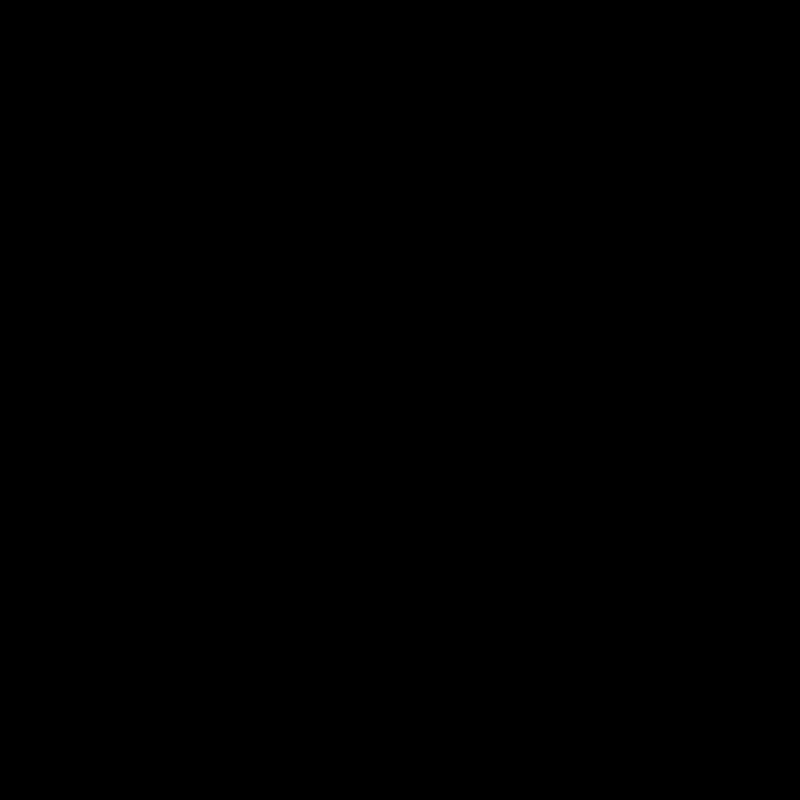

In [39]:
from IPython.display import display
from PIL import Image

model.eval()
with torch.no_grad():
    # Render NeRF output for the held-out validation pose
    nerf_output = render_image(
        model,
        directions,
        val_pose,
        near,
        far,
        samples_per_ray,
        chunk=validation_chunk,
    ).cpu().numpy()

nerf_image = (np.clip(nerf_output, 0.0, 1.0) * 255).astype(np.uint8)
display(Image.fromarray(nerf_image))